In [21]:
#load dataset for CNN 
import os
from PIL import Image
import numpy as np
from scipy.signal import convolve2d
# to read an image from a url
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import torchvision
import torchvision.transforms as T
from torchvision import datasets, transforms
from PIL import Image
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,TensorDataset
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gc

In [2]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Create a tensor on GPU
    device = torch.device('cuda')
    x = torch.tensor([1.0, 2.0]).to(device)
    
    # Create a model and move it to GPU
    model = YourModel().to(device)
    
    # Perform operations on GPU
    output = model(x)
    print(output)
else:
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


In [5]:
#get mean and standard deviation for each image and then average
def compute_image_stats(image_path):
    # Load the image
    image = Image.open(image_path)
    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Compute mean and standard deviation
    mean = np.mean(image_array)
    std = np.std(image_array)
    return mean, std
# Specify the directory containing the images
folder_path = 'data/trainmask'
folder_path2 = 'data/testmask'
def process_images_in_folder(folder_path):
    means = []
    stds = []
    
    # Iterate over all files in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith('.tif'):
            image_path = os.path.join(folder_path, filename)
            mean, std = compute_image_stats(image_path)
            means.append(mean)
            stds.append(std)
            #print(f"Processed {filename}:");
            #print(f"  Mean: {mean}");
            #print(f"  Standard Deviation: {std}");   
    overall_mean = np.mean(means)
    overall_std = np.mean(stds)    
    print(f"\nOverall Mean: {overall_mean}")
    print(f"Overall Standard Deviation: {overall_std}")

# Specify the directory containing the images
folder_path = '/Users/kskruber/Documents/DUDL_PythonCode/convolution/data/trainmask'
folder_path2 = '/Users/kskruber/Documents/DUDL_PythonCode/convolution/data/testmask'
# Process all images in the folder
process_images_in_folder(folder_path);


Overall Mean: nan
Overall Standard Deviation: nan


In [7]:
transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize((54.2/255,), (102.63/255,))  # Mean and std dev
])
transform2 = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize((62.66,), (109.06,))  # Mean and std dev
])
transform_binary = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.ToTensor()  #  scale the pixel values from 0-255 to 0-1
])

In [9]:
# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(folder_path, transform=transform_binary)
test_dataset = datasets.ImageFolder(folder_path2, transform=transform_binary)

In [11]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=6, pin_memory=True,shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, pin_memory=True,shuffle=True, num_workers=4)
print(f"Number of images in train dataset: {len(train_dataset)}")

Number of images in train dataset: 130


In [13]:
# size check (images, channels,  width,  height)
image, label = train_dataset[0]
print(f"Shape of a single image: {image.shape}")

Shape of a single image: torch.Size([1, 1024, 1024])


In [15]:
def createNNmodel(num_classes=1,printtoggle=False):
    class testNet(nn.Module):
        def __init__(self, num_classes,printtoggle):
            super().__init__()
            self.print = printtoggle  # Initialize print attribute

            ### Convolution layers
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer

            # Calculate expected size after convolution and pooling
            expectSize = 20 * 254 * 254  # Assuming input size 1024x1024 after convolutions and pooling

            ### Fully-connected layers
            self.fc1 = nn.Linear(expectSize, 50)
            self.out = nn.Linear(50, 1)  # Output layer

        def forward(self, x):
            if self.print:
                print(f'Input: {x.shape}')
            
            # First convolution -> maxpool -> ReLU
            x = self.pool(F.relu(self.conv1(x)))
            if self.print:
                print(f'Layer conv1/pool1: {x.shape}')
            
            # Second convolution -> maxpool -> ReLU
            x = self.pool(F.relu(self.conv2(x)))
            if self.print:
                print(f'Layer conv2/pool2: {x.shape}')
            
            # Flatten the tensor for the fully connected layers
            x = x.view(-1, self.num_flat_features(x))
            if self.print:
                print(f'Flattened: {x.shape}')
            
            # Fully connected layers with ReLU activation
            x = F.relu(self.fc1(x))
            if self.print:
                print(f'Layer fc1: {x.shape}')
            
            # Output layer
            x = self.out(x)
            if self.print:
                print(f'Layer out: {x.shape}')
            return x

        def num_flat_features(self, x):
            size = x.size()[1:]  # All dimensions except the batch dimension
            num_features = 1
            for s in size:
                num_features *= s
            return num_features
        
    # Create the model instance
    net = testNet(num_classes=num_classes, printtoggle=printtoggle)
    # Loss function for classification
    lossfun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    return net, lossfun, optimizer

In [44]:
#one batch test
net,lossfun,optimizer = createNNmodel(True)

for X, y in train_loader:
    yHat = net(X)
    yHat = yHat.view(-1)  # Flatten the output to match y
    y = y.float()  # Convert target to float
    loss = lossfun(yHat, y)

    # check sizes of outputs
    #print('Predicted category yHat:')
    #print(yHat.shape)
    #print('Predicted category y:')
    #print(y.shape)
    #compute the loss
    loss = lossfun(yHat,y)
    #print(' ')
    #print('Loss:')
    #print(loss)

    # check sizes of model outputs and target variable
    print(' ')
    print(y.shape)
    print(yHat.shape)

 
Loss:
tensor(0.6770, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.7103, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.7115, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.6936, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.6767, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.6934, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.7108, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.7286, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.7285, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
 
torch.Size([6])
torch.Size([6])
 
Loss:
tensor(0.6948, grad_fn=<BinaryCrossEnt

In [75]:
yHat

tensor([0.1274, 0.1277], grad_fn=<ViewBackward0>)

In [23]:
def model_train():
  # number of epochs
  numepochs = 25

  # create a new model
  net,lossfun,optimizer = createNNmodel()
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs
  for epochs in range(numepochs):
    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
     # forward pass and loss
      yHat = net(X)
      yHat = yHat.view(-1)  # Flatten the output to match y
      y = y.view(-1).float()  # Convert target to float
      loss = lossfun(yHat, y)
            
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # loss from this batch
      batchLoss.append(loss.item())
        
      # compute accuracy
      #matches = torch.argmax(yHat,dim=1) == y     # booleans (false/true)
      #matchesNumeric = matches.float()             # convert to numbers (0/1)
      #accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      #batchAcc.append( accuracyPct )               # add to list of accuracies

      predictions = torch.round(torch.sigmoid(yHat))  # Get binary predictions
      matches = predictions == y  # Compare with targets
      accuracyPct = 100 * torch.mean(matches.float())  # Calculate accuracy
      batchAcc.append(accuracyPct.item())
    # end of batch loop
    #  get ave training accuracy
    trainAcc.append( np.mean(batchAcc) )
    # and get average losses across the batches
    losses[epochs] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
      
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      yHat = yHat.view(-1)
      y = y.view(-1, 1).float()
    predictions = (torch.sigmoid(yHat) > 0.5).float()
    testAcc.append(100 * torch.mean((predictions == y).float()).item())
    # Clear cache after each epoch
    gc.collect()
  # end epochs
  # function output
  return trainAcc,testAcc,losses,net

In [25]:
trainAcc,testAcc,losses,net = model_train();

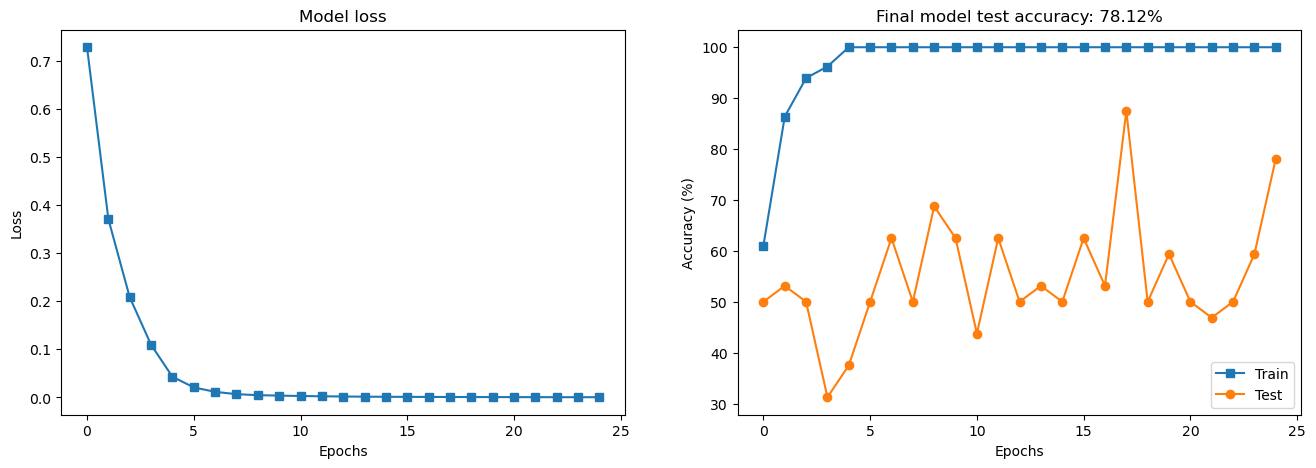

In [27]:
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

In [29]:
def get_all_predictions(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            preds = model(images)
            preds = torch.round(torch.sigmoid(preds.view(-1)))  # Get binary predictions
            all_preds.append(preds.cpu())
            all_labels.append(labels.view(-1).cpu())
    return torch.cat(all_preds), torch.cat(all_labels)

In [31]:
test_preds, test_labels = get_all_predictions(net, test_loader)

In [33]:
cm = confusion_matrix(test_labels.cpu(), test_preds.cpu())

In [235]:
test_preds

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 1., 0.])

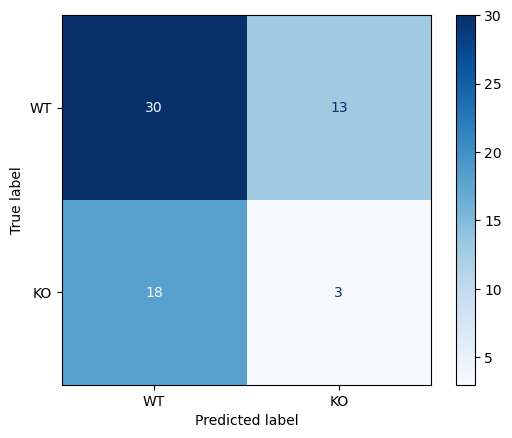

In [35]:
classnames=['WT','KO']
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classnames)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [37]:
testAcc

[50.0,
 53.125,
 50.0,
 31.25,
 37.5,
 50.0,
 62.5,
 50.0,
 68.75,
 62.5,
 43.75,
 62.5,
 50.0,
 53.125,
 50.0,
 62.5,
 53.125,
 87.5,
 50.0,
 59.375,
 50.0,
 46.875,
 50.0,
 59.375,
 78.125]